# DATA.STAT.430 Coursework
Author: Mikhail Shavliuk

## Table of Content:
* [1. Introduction](#1)
* [2. Description of data](#2)
* [3. MCMC simulation](#3)
* [4. Discussion and potential improvements](#4)



## 1. Introduction<a name="1"></a>

About 30,000 people have been treated in the psychiatric hospitals in Finland per year [[1](https://thl.fi/en/web/mental-health/mental-health-services)]. According to THL [[2](https://thl.fi/fi/web/mielenterveys/mielenterveyshairiot/mielialahairiot)] during 2022, at least 5 percent of the adult population suffered from severe depression. There are various treatments for this disease, among which there is one based on the patient's CYP2D6 genotype. To compare this method to the standard approach the trial setting was done and data were collected at the Institute of Living at Hartford Hospital [[3](https://pubmed.ncbi.nlm.nih.gov/31838256/)].

In this work, we will apply bayesian approach to estimate the difference between means of different groups of patients, simulated by Markov Chain Monte Carlo method (MCMC). The simulated data sample will allow to make an informed decision whether the proposed genetically-guided therapy allows to reduce the target parameter (LOS) in comparison with standard therapy. The source code of this Jypyter notebook along with supplementary files can be found in Github [[4](https://github.com/mshavliuk/data.stat.430_course_work)]. Most of the implementation details were omitted from this report and can be found in the aforementioned repository.

## 2. Description of data<a name="2"></a>

CYP-GUIDES (Cytochrome Psychotropic Genotyping Under Investigation for Decision Support) is a randomized controlled trial (RCT) comparing 2 outcomes in hospitalized patients with severe depressive disorders treated according to the patient's CYP2D6 genotype and functional status versus standard psychotropic therapy. The primary outcome was hospital Length of Stay (LOS) and the secondary outcome was the Re-Admission Rate (RAR) 30 days after discharge.

The trial setting was the Institute of Living at Hartford Hospital. CYP2D6 genotyping was implemented to characterize the functional status of the CYP2D6 enzyme with sub-normal, normal, or supra-normal function. The electronic medical record (EMR) was utilized to transmit clinically actionable drug prescribing guidance based on the patient's CYP2D6 function to the physician.

The RCT recruited 1500 patients, genotyped CYP2D6 in 1459, and randomized 477 to standard therapy (Group S), for whom treatment-as-usual guidance was delivered without consideration of patient CYP2D6 genotype, and 982 to genetically-guided therapy (Group G) where CYP2D6-based treatment recommendations were provided via EMR to physicians.

The data was published on Kaggle [[5](https://www.kaggle.com/datasets/shashwatwork/clinical-dataset-of-the-cypguides-trial)] under CC BY 4.0 licence, which allows to use it freely.



,Assignment,LOS
ID,,
1,G,70
2,G,309
3,G,376
4,G,115
5,S,120
6,S,120
7,G,113
17,S,116
23,S,92


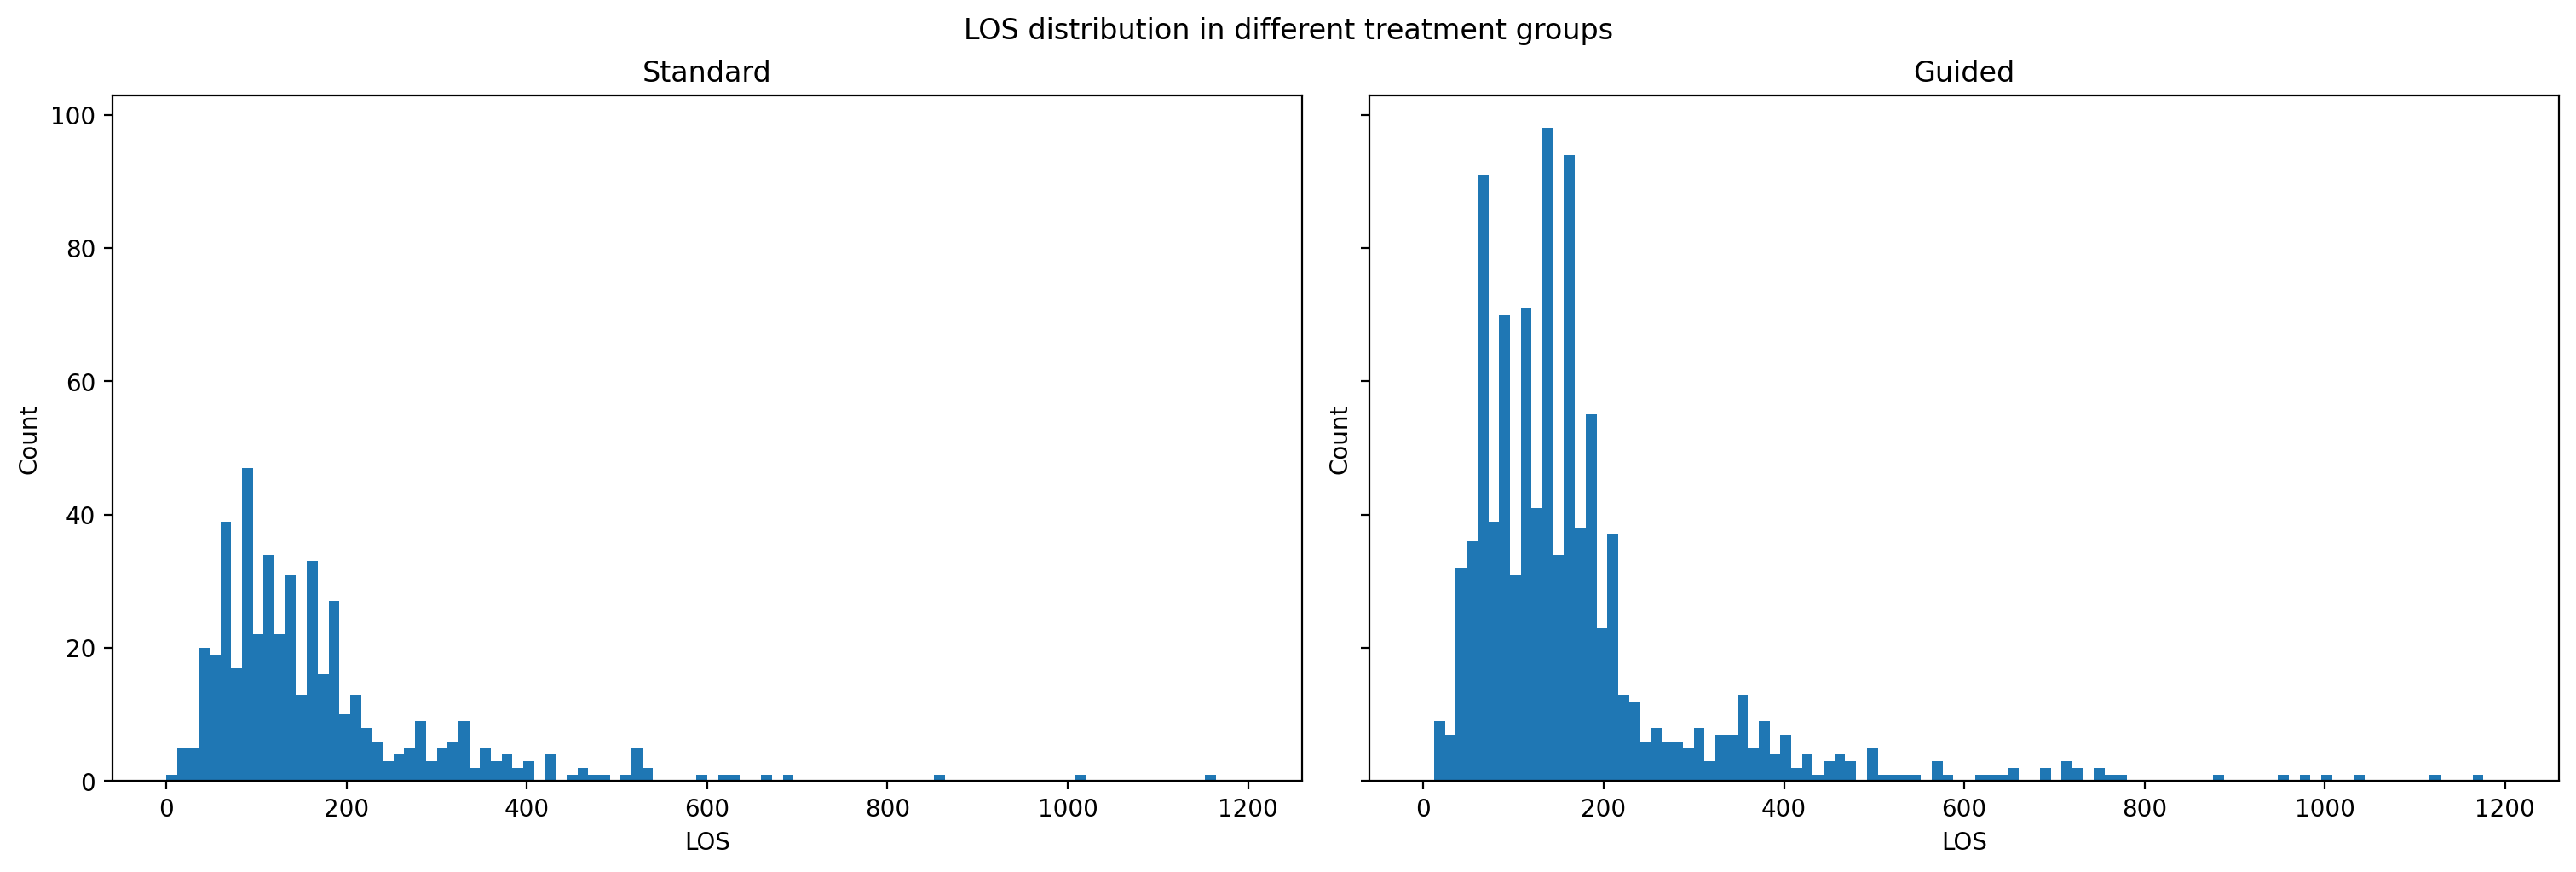

In [5]:
from main import *

standard_treatment, guided_treatment = get_data()

## 3. MCMC simulation<a name="3"></a>

Although the number of data points is not too small, the group sizes are not equal, which may introduce some bias during mean comparison. Moreover, both distributions seem to be multimodal with modes around 100 and 300 LOS but since they are not smooth and have a jitter it may occur just by chance. These reasons justify simulating more data with the bayesian approach using Markov Chains.
> Markov chain simulation is a general method based on drawing values of $\theta$ from approximate distributions and then correcting those draws to better approximate the target posterior distribution, $p(\theta|y)$. The sampling is done sequentially, with the distribution of the sampled draws depending on the last value drawn; hence, the draws form a Markov chain. [[6](http://www.stat.columbia.edu/~gelman/book/)]

The sampling algorithm was implemented Ad-hoc using native Python functions along with SciPy library [[7](https://docs.scipy.org)] for computing prior and approximating the likelihood distribution.

### Prior
It was decided to use gamma distribution prior. It reflects the initial beliefs about the nature of studied data - it is defined on $(0; +\infty)$ range, rises at the beginning and declines slowly, acting as a weakly informative prior. The shape of the distribution can be seen on the posterior plots provided later in this report.

$$
p(x)={\frac {\beta ^{\alpha }}{\Gamma (\alpha )}}x^{\alpha -1}e^{-\beta x}
$$
where parameters $\alpha$ and $\beta$ are set to 1.05 and 1000 respectively.

### Likelyhood

The log probability density function (LPDF) for the likelihood was obtained from the data using the kernel density estimation (KDE) provided by SciPy library [[8](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html)]. Thus, the prior is not conjugate with the likelihood, which means that the posterior distribution can not be computed exactly, but still may be approximated with a simulation.



In [6]:
prior = get_prior()

,Mean,Variance,Mode,95% CI
0,1050.00,1050000.00,50.00,"[30.89, 3793.23]"


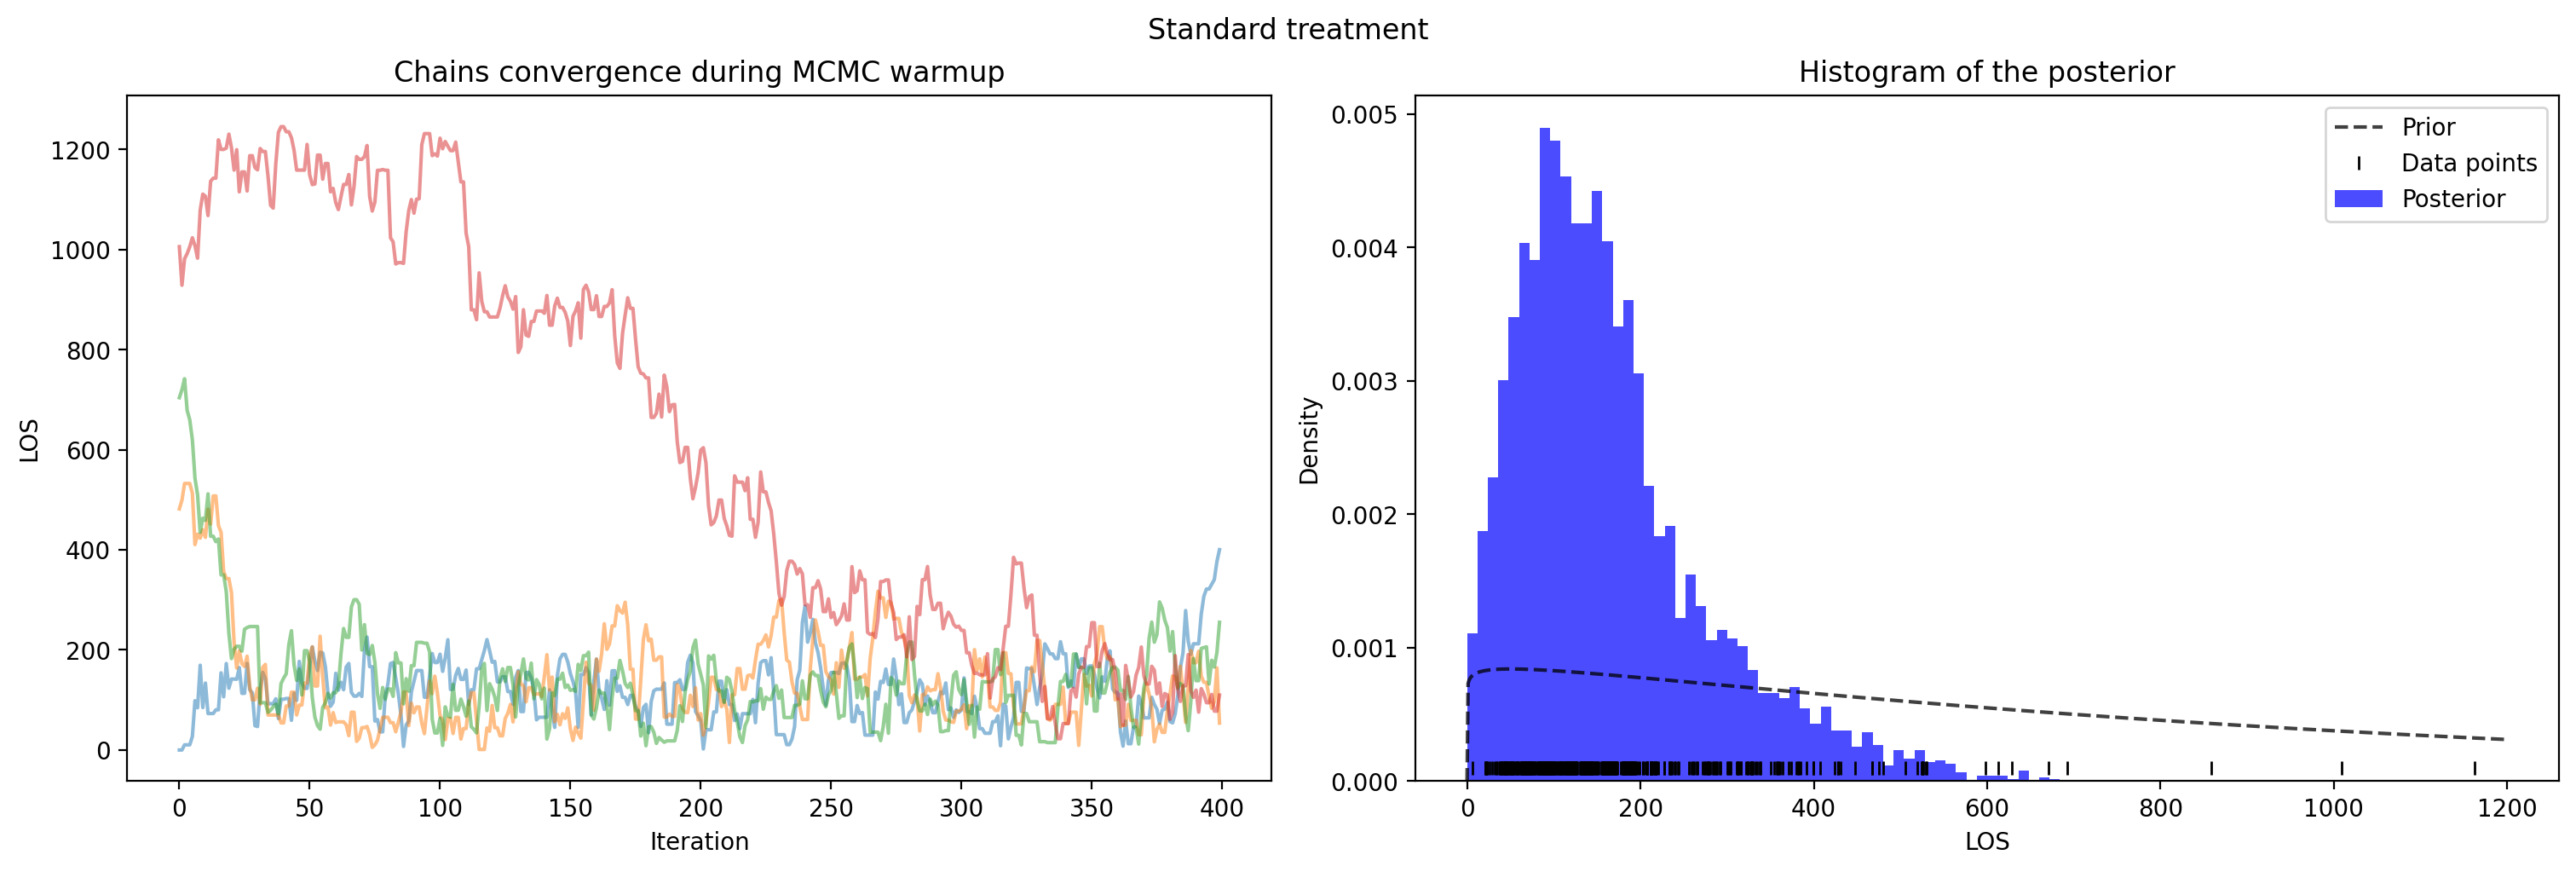

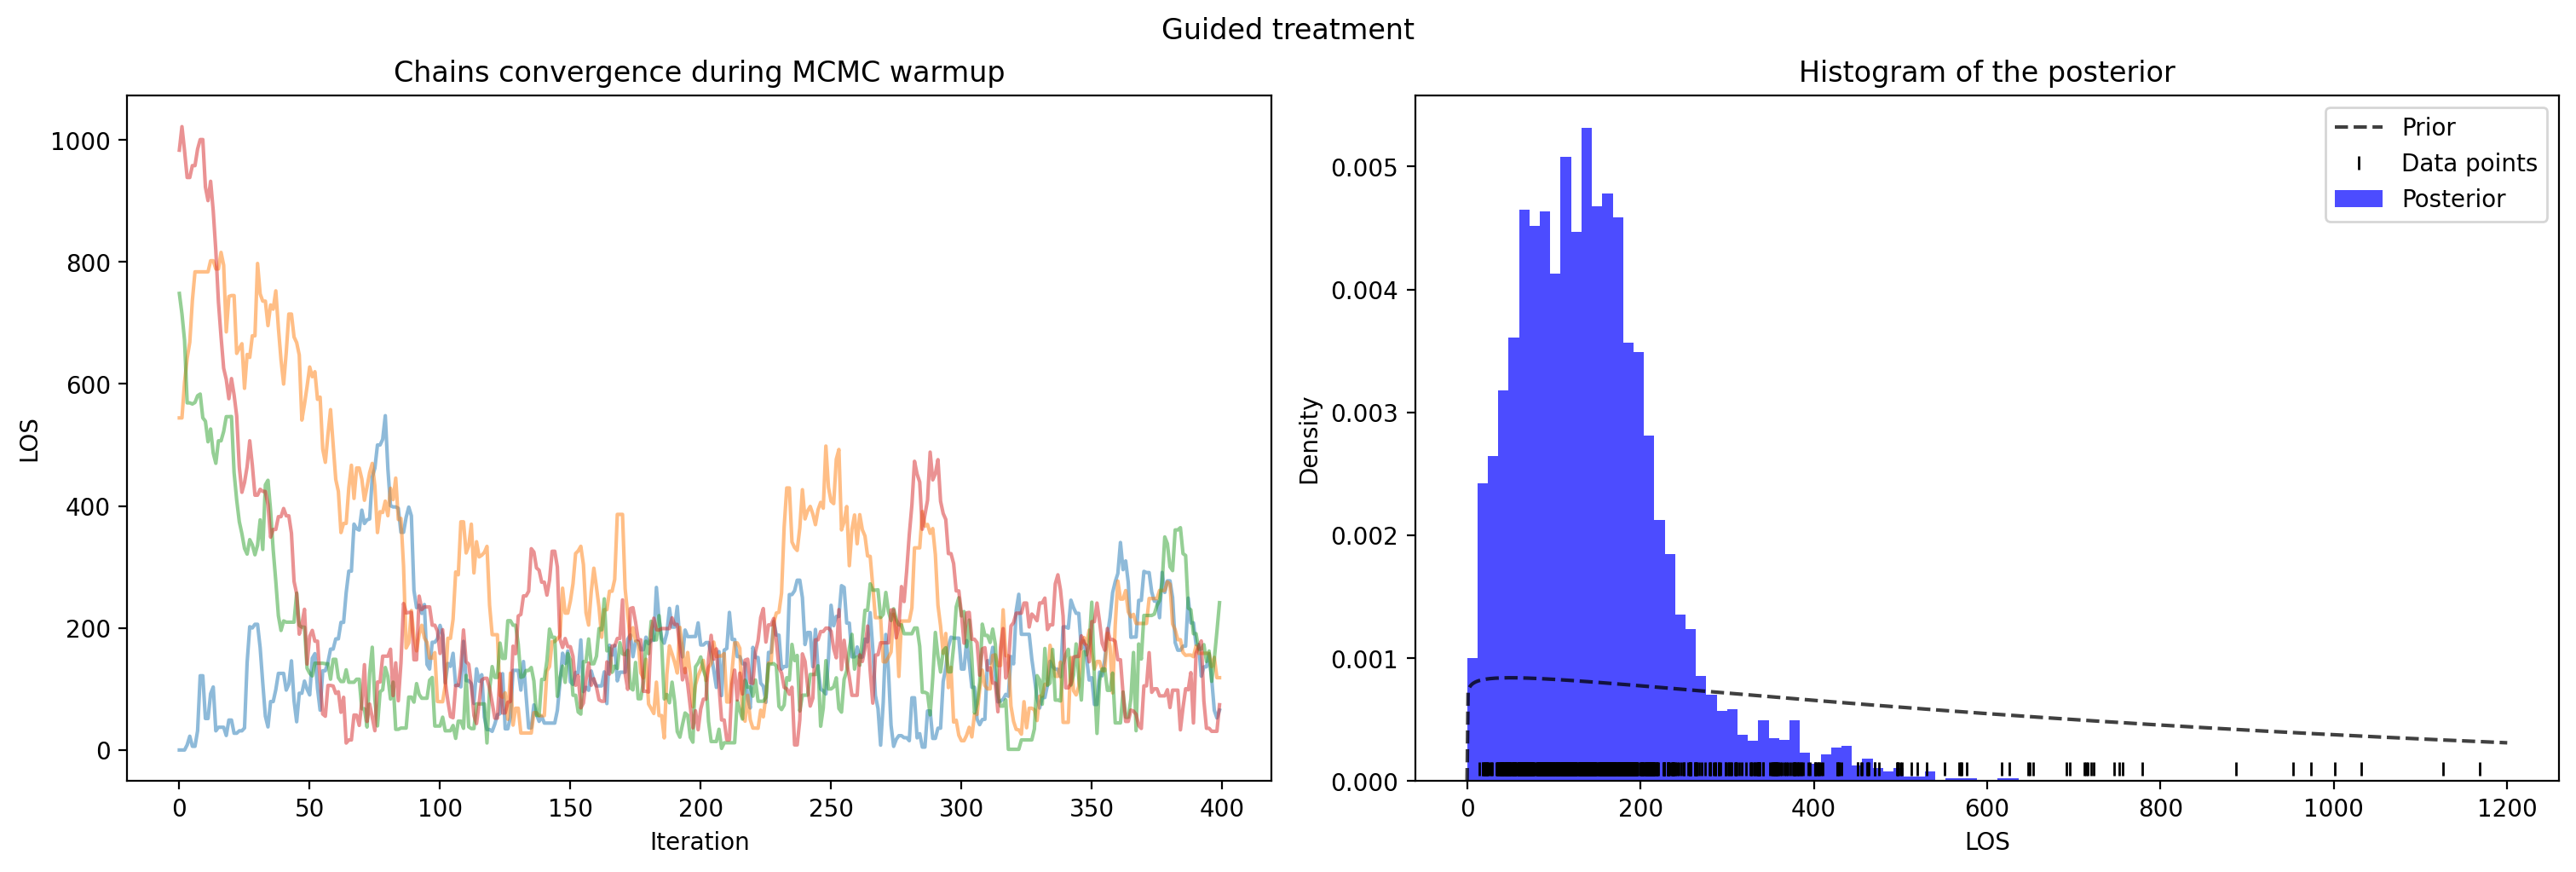

In [7]:
rs = np.random.RandomState(1337)
standard_samples = get_posterior(standard_treatment['LOS'], prior, 'Standard treatment', rs)
guided_samples = get_posterior(guided_treatment['LOS'], prior, 'Guided treatment', rs)

- The left part of the figures above provides a view on the different Markov chains convergence during a warmup sampling. They demonstrate good convergence after 400 initial samples. Warmup samples were removed from the final samples set resulting in 6400 entries in each posterior set.
- On the right side are the plots of a prior, likelihood and posterior distributions on the same scale.

Having a simulated sets of the same size we can obtain the difference between two groups and estimate the 95% confidence interval.

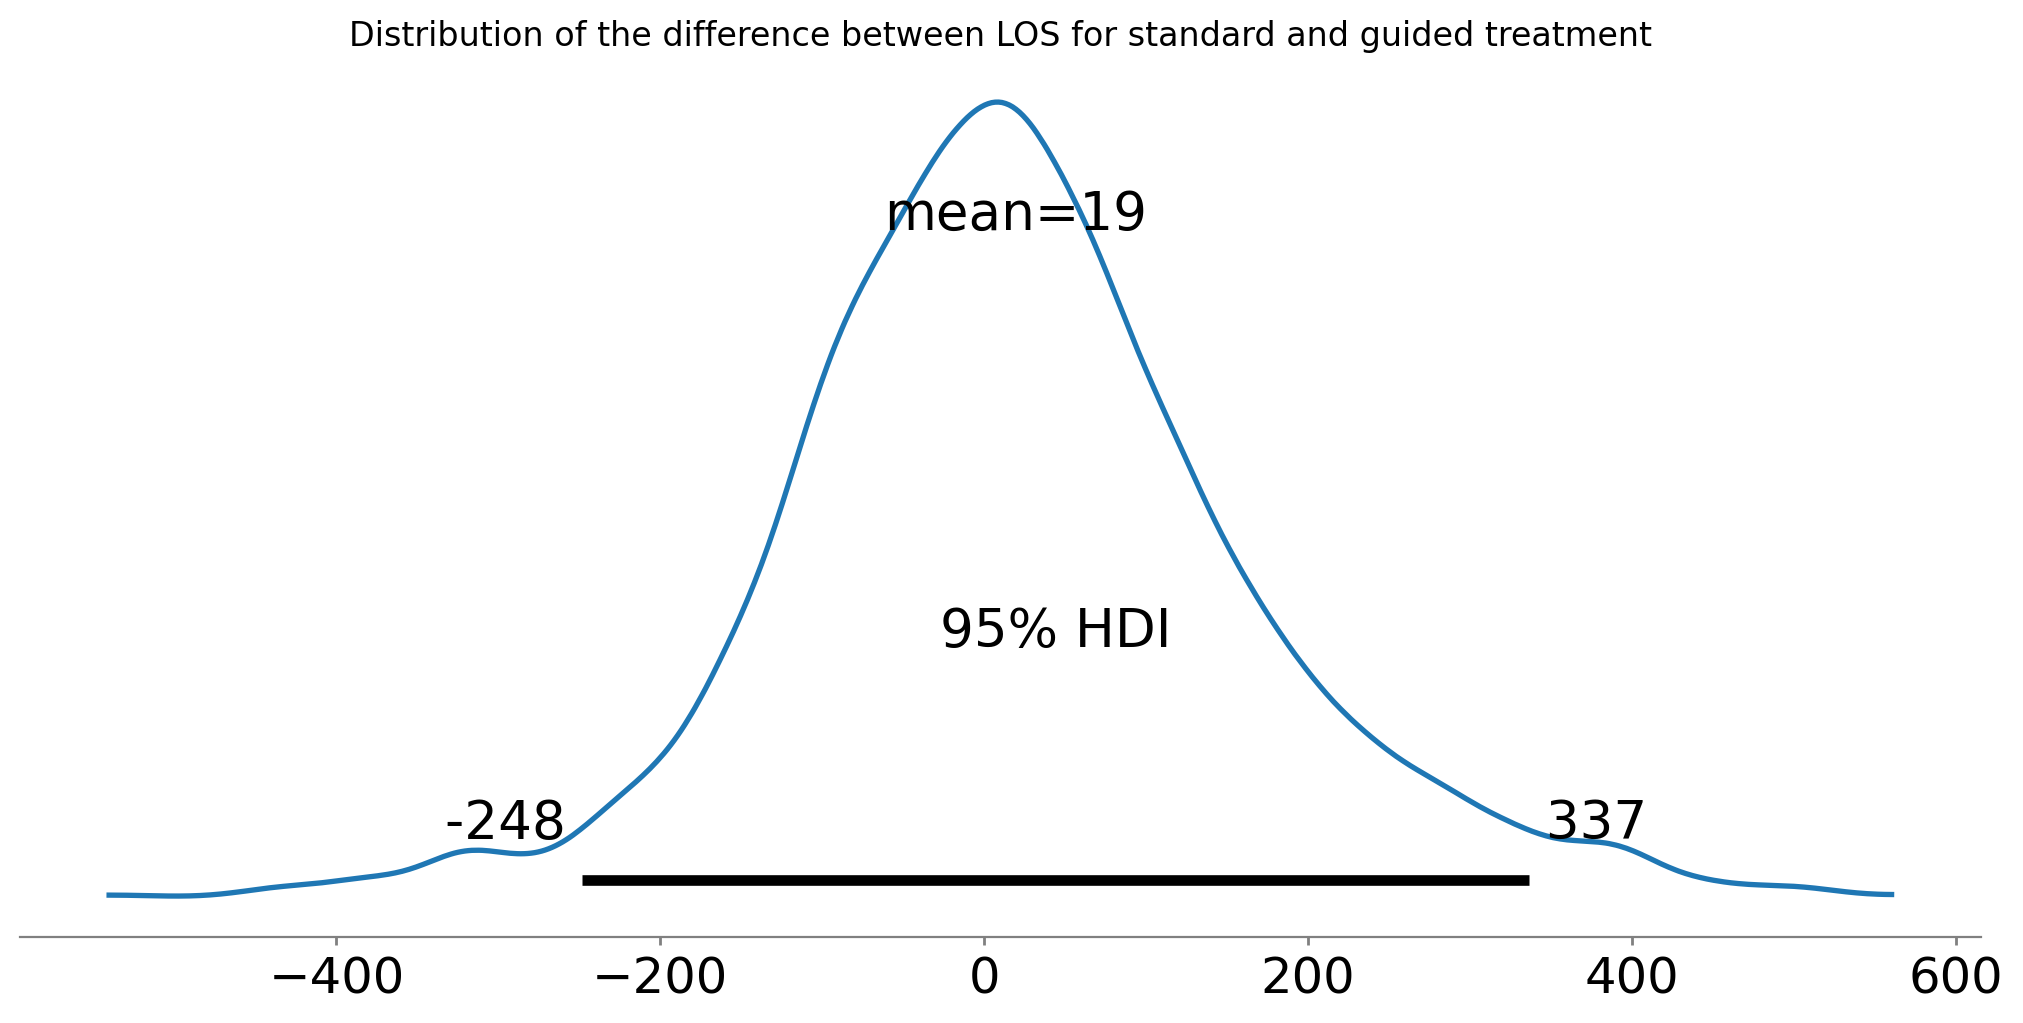

In [8]:
compare_posteriors(standard_samples, guided_samples)

## 4. Discussion and potential improvements<a name="4"></a>
The mean of a difference between guided and standard treatment groups is positive, which might be caused by improvements in treatment. Nonetheless, the results are far from being statistically significant, with 95% interval of difference in LOS between 2 groups from -230 to 325, which means that the Null-hypothesis can not be rejected based on provided data.


### Potential improvements

- Choose more advanced sampler like no-U-turn sampler (NUTS) (ref: [https://arxiv.org/abs/1111.4246](https://arxiv.org/abs/1111.4246))
- The convergence of Markov chains could be more formally assessed by using a convergence diagnostic $\hat{R}$ (ref: [arXiv:1903.08008v5](arXiv:1903.08008v5))
